In [1]:
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Initialize WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(options=options)

def force_english_google_maps(url):
    if "hl=" not in url:
        if "?" in url:
            return f"{url}&hl=en"
        else:
            return f"{url}?hl=en"
    return url

# URL of the Google Maps Reviews Tab (CHANGE ACCORDINGLY)
url = "https://www.google.com/maps/place/Rocco/@38.7095589,-9.1427562,17z/data=!4m8!3m7!1s0xd19350ba8da715b:0x91127b4f8a748afa!8m2!3d38.7095547!4d-9.1401813!9m1!1b1!16s%2Fg%2F11r_xmytsv?entry=ttu&g_ep=EgoyMDI0MTIxMS4wIKXMDSoASAFQAw%3D%3D"
url = force_english_google_maps(url)
driver.get(url)

# Step 1: Accept Cookies
try:
    accept_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//button[contains(@class, "UywwFc-LgbsSe")]'))
    )
    accept_button.click()
    print("Cookies accepted.")
except Exception as e:
    print(f"Error accepting cookies: {e}")

# Step 2: Locate the Scrollable Reviews Container
try:
    scrollable_div = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//div[contains(@class, "m6QErb") and contains(@class, "DxyBCb")]'))
    )
    print("Scrollable reviews container found.")
except Exception as e:
    print(f"Error locating scrollable container: {e}")
    driver.quit()
    exit()

# Step 3: Scroll through Reviews Dynamically
last_height = 0
retry_count = 0
max_retries = 5  # Maximum retries when no new reviews load

while retry_count < max_retries:
    # Scroll to the bottom
    driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scrollable_div)
    time.sleep(2)  # Allow time for reviews to load

    # Check if new reviews are loaded
    current_height = driver.execute_script("return arguments[0].scrollHeight", scrollable_div)
    if current_height == last_height:
        retry_count += 1
        print(f"No new reviews loaded, retry {retry_count}/{max_retries}")
    else:
        retry_count = 0  # Reset retry count if new reviews are loaded
        last_height = current_height
        print("New reviews loaded...")

print("Scrolling complete.")

# Step 4: Extract Reviews
reviews_df = []
try:
    review_elements = driver.find_elements(By.XPATH, '//span[@class="wiI7pd"]')  # Review content
    star_elements = driver.find_elements(By.XPATH, '//span[@class="kvMYJc"]')  # Star ratings
    date_elements = driver.find_elements(By.XPATH, '//span[@class="rsqaWe"]')  # Review age

    for review, star, date in zip(review_elements, star_elements, date_elements):
        reviews_df.append({
            "review": review.text,
            "stars": star.get_attribute("aria-label"),
            "date": date.text
        })
    print(f"Extracted {len(reviews_df)} reviews_df.")
except Exception as e:
    print(f"Error extracting reviews: {e}")
    
# Close the WebDriver
driver.quit()
reviews_df = pd.DataFrame(reviews_df)
print(reviews_df.head())

Cookies accepted.
Scrollable reviews container found.
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
New reviews loaded...
No new reviews loaded, retry 1/5
No new reviews loaded, retry 2/5
No new reviews loaded, retry 3/5
No new reviews loaded, retry 4/5
No new reviews loaded,

In [3]:
reviews_df["score"] = reviews_df["stars"].str.extract(r'(\d+)').astype(int)

In [4]:
# Function to calculate the review date
def calculate_review_date(row_date):
    now = datetime.now()
    try:
        if "month" in row_date:
            if "a month ago" in row_date:  # Special case for "a month ago"
                return now - timedelta(days=30)
            months = int(row_date.split()[0])
            return now - timedelta(days=30 * months)
        elif "year" in row_date:
            if "a year ago" in row_date:  # Special case for "a year ago"
                return now - timedelta(days=365)
            years = int(row_date.split()[0])
            return now - timedelta(days=365 * years)
        elif "week" in row_date:
            if "a week ago" in row_date:  # Special case for "a week ago"
                return now - timedelta(weeks=1)
            weeks = int(row_date.split()[0])
            return now - timedelta(weeks=weeks)
        elif "day" in row_date:
            if "a day ago" in row_date:  # Special case for "a day ago"
                return now - timedelta(days=1)
            days = int(row_date.split()[0])
            return now - timedelta(days=days)
        else:
            return None  # Fallback for unexpected formats
    except (ValueError, IndexError):
        return None

# Apply the updated function to the 'date' column
reviews_df["date_of_review"] = reviews_df["date"].apply(calculate_review_date)

# Display the updated DataFrame
reviews_df.head()
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   review          360 non-null    object        
 1   stars           360 non-null    object        
 2   date            360 non-null    object        
 3   score           360 non-null    int64         
 4   date_of_review  360 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 14.2+ KB


In [5]:
df = reviews_df.copy()

# Preprocessing: Removing special characters and converting to lowercase
df["cleaned_review"] = df["review"].str.replace(r"[^a-zA-Z\s]", "", regex=True).str.lower()

In [6]:
# Word count
df["word_count"] = df["cleaned_review"].apply(lambda x: len(x.split()))

# Sentence count
df["sentence_count"] = df["review"].apply(lambda x: len(x.split(".")))

# Display average stats
print(f"Average word count: {df['word_count'].mean()}")
print(f"Average sentence count: {df['sentence_count'].mean()}")

Average word count: 33.87222222222222
Average sentence count: 3.4277777777777776


In [7]:
### 1. Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# 1. Sentiment Analysis with VADER
def calculate_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores["compound"]

# Apply the sentiment analysis to the 'review' column
reviews_df['sentiment_score'] = reviews_df['review'].apply(calculate_sentiment)

# Basic sentiment categorization
reviews_df['sentiment_category'] = pd.cut(
    reviews_df['sentiment_score'],
    bins=[-1, -0.05, 0.05, 1],
    labels=["Negative", "Neutral", "Positive"]
)

In [8]:
### 2. Aspect-Based Sentiment Analysis (Simplified Example)
aspects = ["food", "service", "ambiance", "price", "cleanliness"]
aspect_sentiments = {aspect: [] for aspect in aspects}

for _, row in reviews_df.iterrows():
    review_text = row['review'].lower()
    for aspect in aspects:
        if aspect in review_text:
            aspect_sentiments[aspect].append(row['sentiment_score'])

# Calculate average sentiment for each aspect
aspect_avg_sentiment = {
    aspect: (sum(scores) / len(scores)) if scores else 0
    for aspect, scores in aspect_sentiments.items()
}

In [9]:
### 3. Topic Modeling
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(reviews_df['review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components as needed
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [10]:
# Extract top words per topic
words = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-11:-1]  # Top 10 words
    top_features = [words[i] for i in top_features_ind]
    topics[topic_idx] = top_features

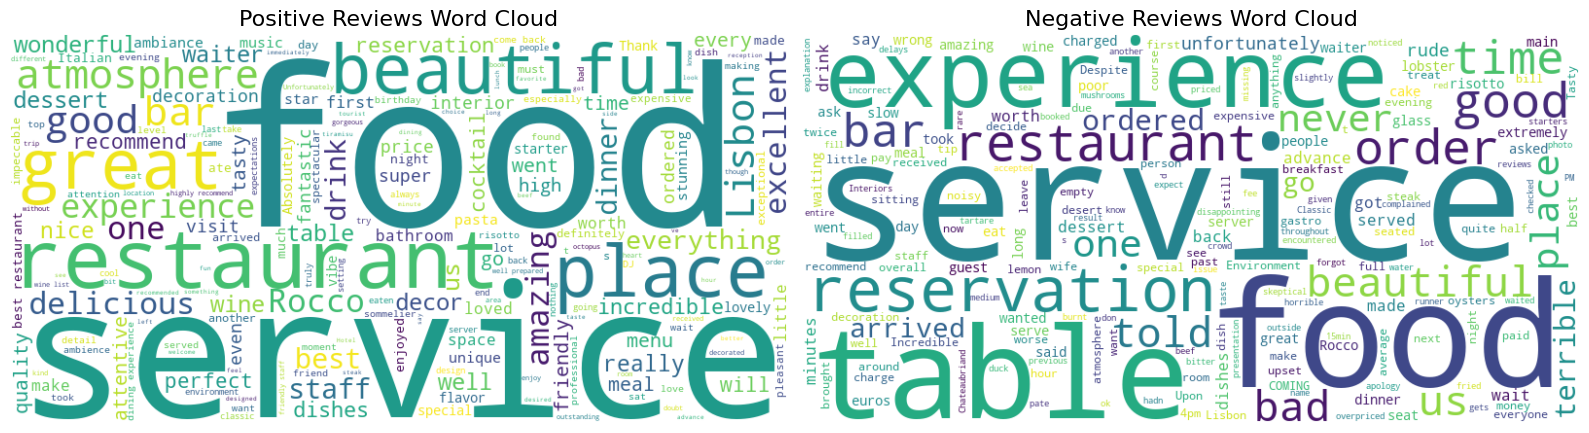

In [11]:
### 4. Keyword and Phrase Extraction by Sentiment

# Filter positive and negative reviews
positive_reviews = reviews_df[reviews_df['sentiment_category'] == "Positive"]
negative_reviews = reviews_df[reviews_df['sentiment_category'] == "Negative"]

# Generate word cloud for positive reviews
positive_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(' '.join(positive_reviews['review']))

# Generate word cloud for negative reviews
negative_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(' '.join(negative_reviews['review']))

# Plot word clouds side by side
plt.figure(figsize=(16, 8))

# Positive word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud', fontsize=16)

# Negative word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud', fontsize=16)

plt.tight_layout()
plt.show()

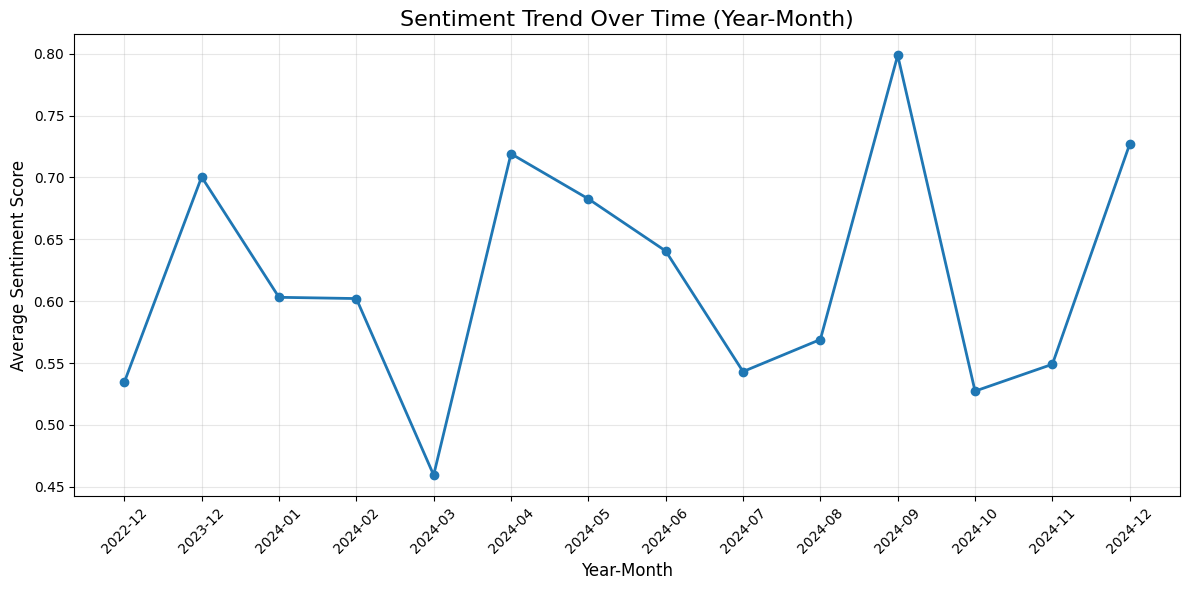

In [12]:
### 5. Sentiment Trends Over Time
# Convert 'date' column to datetime if not already in datetime format
reviews_df['date_of_review'] = pd.to_datetime(reviews_df['date_of_review'])

# Group by year-month and calculate average sentiment score
sentiment_trend = reviews_df.groupby(reviews_df['date_of_review'].dt.to_period("M"))['sentiment_score'].mean()

# Convert index to string for clearer x-axis labels
sentiment_trend.index = sentiment_trend.index.astype(str)

# Plot the sentiment trend
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index, sentiment_trend.values, marker='o', linestyle='-', linewidth=2)
plt.title("Sentiment Trend Over Time (Year-Month)", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Top Positive Bigrams:


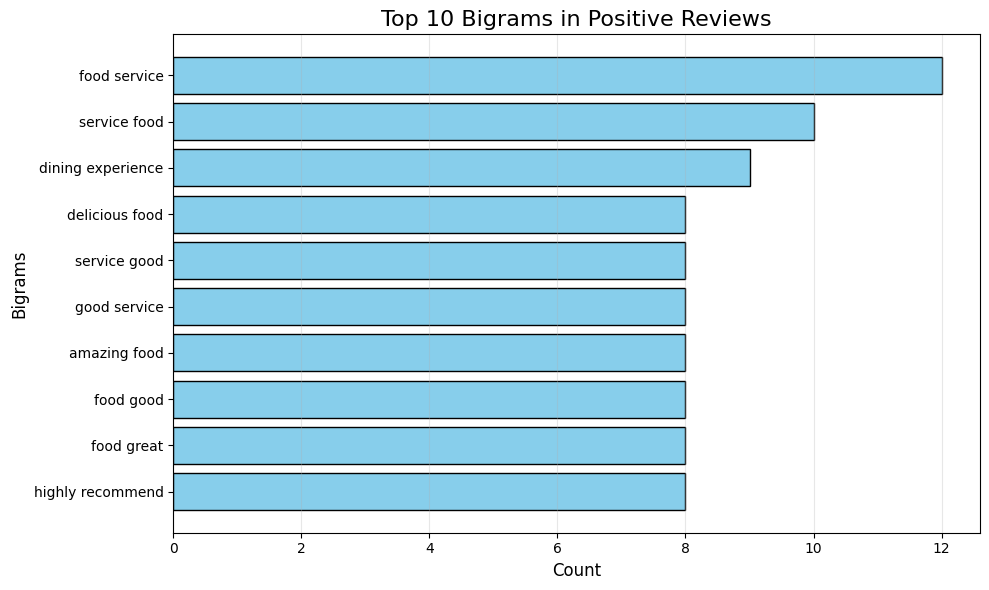


Top Negative Bigrams:


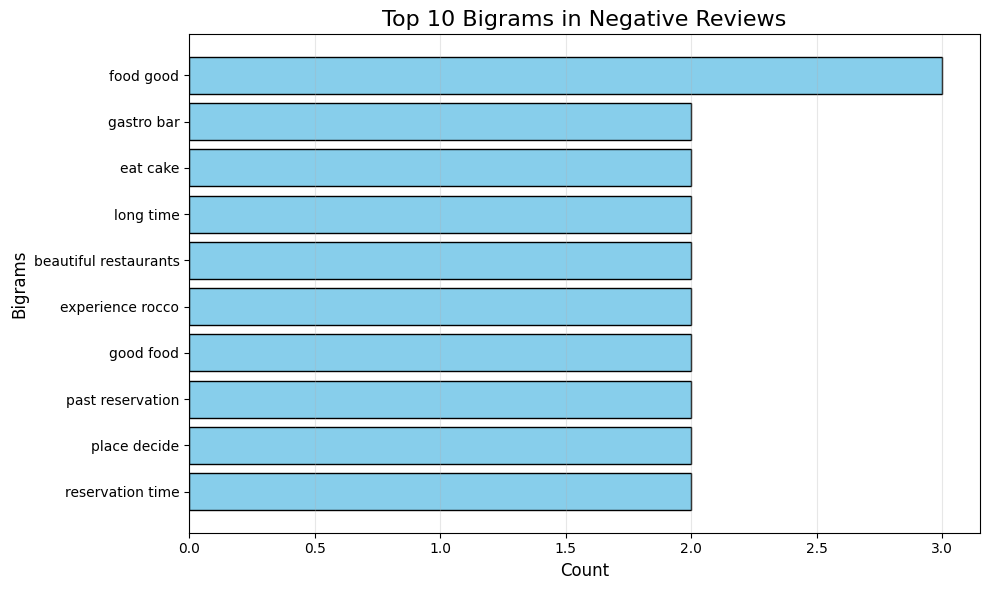


Top Overall Bigrams:


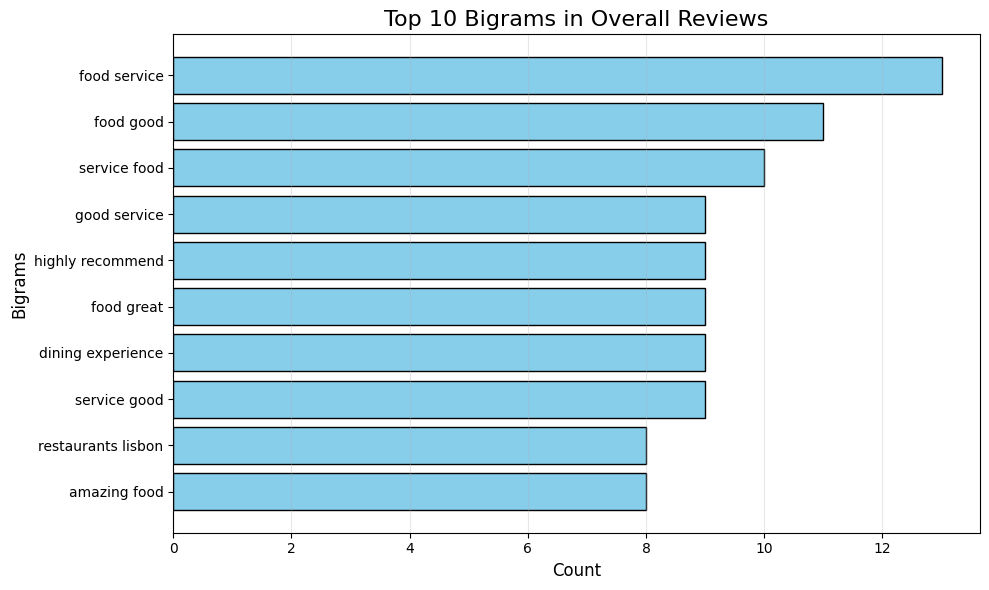

In [13]:
### 6. Bigrams Analysis

def extract_top_bigrams(reviews, n=10):
    """Extract the top bigrams from a given list of reviews_df."""
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    bigrams_matrix = vectorizer.fit_transform(reviews)
    bigrams_sum = bigrams_matrix.sum(axis=0)  # Sum up the occurrences of each bigram
    
    # Get bigram names and their counts
    bigrams = vectorizer.get_feature_names_out()
    counts = bigrams_matrix.toarray().sum(axis=0)
    bigrams_df = pd.DataFrame({'bigram': bigrams, 'count': counts})
    bigrams_df = bigrams_df.sort_values(by='count', ascending=False).head(n)
    return bigrams_df

# Separate reviews based on sentiment
positive_reviews = reviews_df[reviews_df['sentiment_category'] == "Positive"]['review']
negative_reviews = reviews_df[reviews_df['sentiment_category'] == "Negative"]['review']
all_reviews = reviews_df['review']

# Extract top bigrams
top_positive_bigrams = extract_top_bigrams(positive_reviews, n=10)
top_negative_bigrams = extract_top_bigrams(negative_reviews, n=10)
top_overall_bigrams = extract_top_bigrams(all_reviews, n=10)

# Function to plot bigrams
def plot_bigrams(bigrams_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(bigrams_df['bigram'], bigrams_df['count'], color='skyblue', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Bigrams', fontsize=12)
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot bigrams for positive, negative, and overall reviews
print("\nTop Positive Bigrams:")
plot_bigrams(top_positive_bigrams, "Top 10 Bigrams in Positive Reviews")

print("\nTop Negative Bigrams:")
plot_bigrams(top_negative_bigrams, "Top 10 Bigrams in Negative Reviews")

print("\nTop Overall Bigrams:")
plot_bigrams(top_overall_bigrams, "Top 10 Bigrams in Overall Reviews")


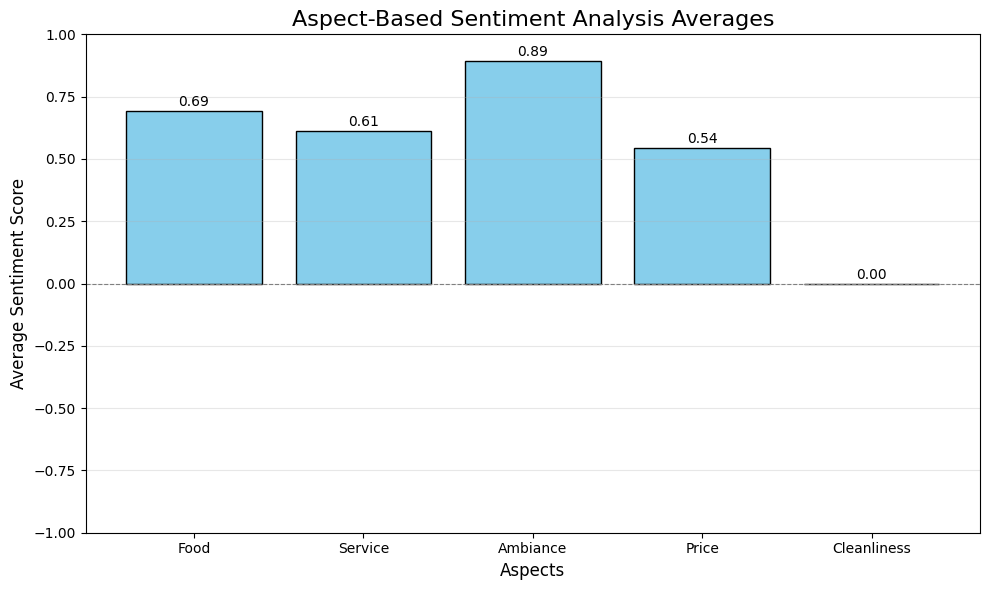


Top Words in Topics:

Topic 1:
food, restaurant, rocco, great, bar, place, service, lisbon, beautiful, experience

Topic 2:
food, great, delicious, wine, restaurant, service, lisbon, bar, incredible, perfect

Topic 3:
food, restaurant, bar, beautiful, service, good, lisbon, atmosphere, best, place

Topic 4:
service, food, amazing, place, dinner, great, lisbon, beautiful, restaurant, table

Topic 5:
service, food, restaurant, place, atmosphere, experience, beautiful, good, great, recommend


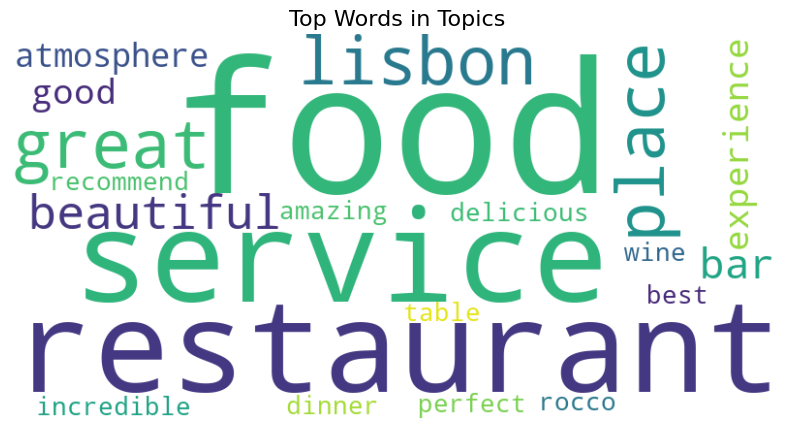


Sample Negative Reviews (Complaints):


,review
33,"Classic dishes. Tasty, but overpriced. Service is slow and gets upset if you don't order wine or don't want desert. It's ok overall, just not worth the money they ask for this experience."
34,"I made reservations well in advance but still had to wait over 10-15min past my reservation time for a seat. Upon sitting down, I noticed a lot of empty tables next to us that never got filled throughout the entire dinner so I don’t …"
52,"They served the meal you see in the photo in 1.5 hours. We waited for a very long time, they said the service was slow because of the crowd. We never got what I paid for. The service was very bad. They also forgot our dessert orders and one …"
104,"It was amazing evening in the gastro bar. I was skeptical since I have red some bad reviews about the service. We had duck pate, fried sea food, beef tartare, mushrooms risotto, lemon cake, …"
105,"I had a disappointing experience .I booked a table in advance for 10:15 PM, arrived on time, but was told I’d have to wait due to delays from previous guests. Despite waiting 45 minutes past my reservation time, I still hadn’t been seated, …"


In [14]:
from tabulate import tabulate

### 7. Complaint Detection

# Filter reviews with negative sentiment
complaints = reviews_df[reviews_df['sentiment_category'] == "Negative"]

### Results Summary

# 1. Aspect-Based Sentiment Analysis Averages

# Plot Aspect-Based Sentiment Analysis Averages in a Bar Chart
aspects = [aspect.capitalize() for aspect in aspect_avg_sentiment.keys()]
average_sentiments = list(aspect_avg_sentiment.values())

plt.figure(figsize=(10, 6))
plt.bar(aspects, average_sentiments, color='skyblue', edgecolor='black')
plt.title("Aspect-Based Sentiment Analysis Averages", fontsize=16)
plt.xlabel("Aspects", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.ylim(-1, 1)  # Sentiment polarity ranges from -1 to 1
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Reference line at 0
plt.grid(axis='y', alpha=0.3)

# Annotate each bar with the sentiment score
for i, score in enumerate(average_sentiments):
    plt.text(i, score + 0.02 if score >= 0 else score - 0.05, f"{score:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 2. Top Words in Topics
print("\nTop Words in Topics:")
for topic_num, topic_words in topics.items():
    print(f"\nTopic {topic_num + 1}:")
    print(", ".join(topic_words))

# 3. Display a Word Cloud for Topics
topic_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(" ".join([" ".join(words) for words in topics.values()]))

plt.figure(figsize=(10, 6))
plt.imshow(topic_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words in Topics', fontsize=16)
plt.show()

# 4. Sample Negative Reviews
print("\nSample Negative Reviews (Complaints):")
if not complaints.empty:
    # Display top 5 complaints
    styled_complaints = complaints[['review']].head(5).style.set_properties(**{
        'border': '1px solid black', 
        'padding': '10px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('font-weight', 'bold')]}
    ])
    display(styled_complaints)
else:
    print("No negative reviews found.")

In [15]:
### 8. Verdict

from rich import print
from rich.table import Table

def should_recommend_restaurant(
    reviews, aspect_avg_sentiment, 
    sentiment_threshold=0.2, must_go_threshold=0.4, really_must_go_threshold=0.6,
    complaint_rate_threshold=0.2, must_go_complaint_threshold=0.1, 
    score_threshold=3, critical_aspect_majority=True
):
    """
    Decide whether to recommend a restaurant with a four-level recommendation scale.
    """
    # Adjusted overall sentiment score
    overall_sentiment = reviews['sentiment_score'].mean() * 0.8  # Adjust VADER's positive bias
    
    # Complaint rate (proportion of negative reviews)
    complaint_rate = len(reviews[reviews['sentiment_category'] == "Negative"]) / len(reviews)
    
    # Average score from the 'score' column
    average_score = reviews['score'].mean()
    
    # Check critical aspects for positive sentiment
    critical_aspects = ['food', 'service', 'ambiance', 'price']
    critical_aspect_sentiments = {aspect: sentiment for aspect, sentiment in aspect_avg_sentiment.items() if aspect in critical_aspects}
    
    if critical_aspect_majority:
        # Check if the majority of critical aspects exceed the threshold
        critical_positive_count = sum(sentiment > sentiment_threshold for sentiment in critical_aspect_sentiments.values())
        critical_aspect_pass = critical_positive_count >= (len(critical_aspects) // 2 + 1)
    else:
        # Strict check: all critical aspects must exceed the threshold
        critical_aspect_pass = all(sentiment > sentiment_threshold for sentiment in critical_aspect_sentiments.values())
    
    # Determine recommendation level
    if (overall_sentiment > really_must_go_threshold and complaint_rate < must_go_complaint_threshold and 
        average_score >= score_threshold and critical_aspect_pass):
        recommendation = "[bold green]Really Must Go[/bold green]"
    elif (overall_sentiment > must_go_threshold and complaint_rate < must_go_complaint_threshold and 
          average_score >= score_threshold and critical_aspect_pass):
        recommendation = "[bold green]Must Go[/bold green]"
    elif (overall_sentiment > sentiment_threshold and complaint_rate < complaint_rate_threshold and 
          average_score >= score_threshold and critical_aspect_pass):
        recommendation = "[bold yellow]Recommend[/bold yellow]"
    else:
        recommendation = "[bold red]Do Not Recommend[/bold red]"
    
    # Compile decision details
    details = {
        "Overall Sentiment (Adjusted)": f"{overall_sentiment:.2f}",
        "Complaint Rate": f"{complaint_rate:.2%}",
        "Average Score": f"{average_score:.2f}",
        "Critical Aspects Positive": critical_aspect_pass,
        "Critical Aspect Sentiments": critical_aspect_sentiments,
        "Sentiment Threshold": sentiment_threshold,
        "Must-Go Sentiment Threshold": must_go_threshold,
        "Really Must-Go Sentiment Threshold": really_must_go_threshold,
        "Complaint Rate Threshold": complaint_rate_threshold,
        "Must-Go Complaint Threshold": must_go_complaint_threshold,
        "Score Threshold": score_threshold
    }
    
    return recommendation, details
    
# Run the recommendation decision
recommendation, decision_details = should_recommend_restaurant(reviews_df, aspect_avg_sentiment)

# Print the recommendation
print("\n[bold cyan]Recommendation Summary[/bold cyan]")
print(f"Final Recommendation: {recommendation}\n")

# Display decision details in a table
table = Table(title="Decision Details", title_style="bold magenta")

table.add_column("Metric", justify="left", style="cyan", no_wrap=True)
table.add_column("Value", justify="center", style="bold yellow")

for key, value in decision_details.items():
    table.add_row(key, str(value))

print(table)

Recommendation Summary

Final Recommendation: Recommend

                                                 Decision Details                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                             ┃                                   Value                                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Overall Sentiment (Adjusted)       │                                    0.51                                    │
│ Complaint Rate                     │                                   11.67%                                   │
│ Average Score                      │                                    4.15                                    │
│ Critical Aspects Positive          │                                    True                                    │
│ Critical Aspect Sentiments         │  {'food': 0.6935550898203593, 'service': 0.6121668874172186, 'ambiance':   │
│                                    │              0.8942642857142857, 'price': 0.5427708333333333}              │
│ Sentiment Threshold                │                                    0.2                                     │
│ Must-Go Sentiment Threshold        │                                    0.4                                     │
│ Really Must-Go Sentiment Threshold │                                    0.6                                     │
│ Complaint Rate Threshold           │                                    0.2                                     │
│ Must-Go Complaint Threshold        │                                    0.1                                     │
│ Score Threshold                    │                                     3                                      │
└────────────────────────────────────┴────────────────────────────────────────────────────────────────────────────┘